In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [25]:
data = pd.read_csv('Data/train.csv')

In [26]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data = np.array(data)
m, n = data.shape

In [28]:
np.random.shuffle(data)

In [29]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255.0

In [30]:
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255.0

In [31]:
print(f"Training Data Shape: {X_train.shape}")
print(f"Dev Data Shape: {X_dev.shape}")

Training Data Shape: (784, 41000)
Dev Data Shape: (784, 1000)


In [32]:
def plot_data(data):
    plt.imshow(data.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.show()

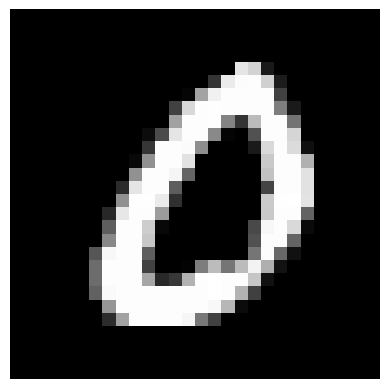

In [33]:
plot_data(X_train[:,199])

In [34]:
def ReLU(Z):
    A = np.maximum(0, Z)
    return A

In [35]:
def ReLU_backward(Z):
    return Z > 0

In [ ]:
def Softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)  # numerical stability
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)


In [37]:
def init_params():
    W1 = np.random.randn(128, 784) * np.sqrt(2/784)
    b1 = np.zeros((128, 1))

    W2 = np.random.randn(64, 128) * np.sqrt(2/128)
    b2 = np.zeros((64, 1))

    W3 = np.random.randn(10, 64) * np.sqrt(2/64)
    b3 = np.zeros((10, 1))

    return W1, b1, W2, b2, W3, b3

In [38]:
def forward_prop(X, W1, b1, W2, b2, W3, b3):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)

    Z3 = W3.dot(A2) + b3
    A3 = Softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3

In [ ]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.max()+1, Y.size))

    one_hot_Y[Y, np.arange(Y.size)] = 1 # this each column = one example
    return one_hot_Y

In [40]:
def backward_prop(X, Y, Z1, A1, Z2, A2, Z3, A3, W2, W3):
    one_hot_Y = one_hot(Y)
    m = Y.size

    dZ3 = A3 - one_hot_Y
    dW3 = (1/m) * dZ3.dot(A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    dZ2 = W3.T.dot(dZ3) * ReLU_backward(Z2)
    dW2 = (1/m) * dZ2.dot(A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T.dot(dZ2) * ReLU_backward(Z1)
    dW1 = (1/m) * dZ1.dot(X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

In [41]:
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3

    return W1, b1, W2, b2, W3, b3

In [ ]:
def compute_cost(A3, Y):
    # Categorical Cross-Entropy Loss
    m = Y.shape[0]
    one_hot_Y = one_hot(Y)
    # epsilon (1e-8) to avoid log(0)
    logprobs = np.multiply(np.log(A3 + 1e-8), one_hot_Y)
    cost = -np.sum(logprobs) / m
    return cost

In [43]:
def get_predictions(A3):
    return np.argmax(A3, 0)

In [ ]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [45]:
def gradient_descent(X, Y, iterations, learning_rate):
    W1, b1, W2, b2, W3, b3 = init_params()

    cost_history = []
    accuracy_history = []
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(X, Y, Z1, A1, Z2, A2, Z3, A3, W2, W3)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3,
                                               dW1, db1, dW2, db2, dW3, db3,
                                               learning_rate)
        if i % 10 == 0:
            cost = compute_cost(A3, Y)
            acc = get_accuracy(get_predictions(A3), Y)
            cost_history.append(cost)
            accuracy_history.append(acc)

            if i % 50 == 0:
                print(f"Iter: {i} | Cost: {cost:.4f} | Accuracy: {acc:.4f}")

    return W1, b1, W2, b2, W3, b3, cost_history, accuracy_history

In [46]:
W1, b1, W2, b2, W3, b3, costs, accs = gradient_descent(X_train, Y_train, 1000, 0.05)

Iter: 0 | Cost: 2.4515 | Accuracy: 0.0679
Iter: 50 | Cost: 0.8478 | Accuracy: 0.8066
Iter: 100 | Cost: 0.5164 | Accuracy: 0.8660
Iter: 150 | Cost: 0.4182 | Accuracy: 0.8859
Iter: 200 | Cost: 0.3695 | Accuracy: 0.8963
Iter: 250 | Cost: 0.3388 | Accuracy: 0.9040
Iter: 300 | Cost: 0.3167 | Accuracy: 0.9096
Iter: 350 | Cost: 0.2994 | Accuracy: 0.9141
Iter: 400 | Cost: 0.2851 | Accuracy: 0.9184
Iter: 450 | Cost: 0.2729 | Accuracy: 0.9224
Iter: 500 | Cost: 0.2622 | Accuracy: 0.9256
Iter: 550 | Cost: 0.2526 | Accuracy: 0.9286
Iter: 600 | Cost: 0.2440 | Accuracy: 0.9310
Iter: 650 | Cost: 0.2361 | Accuracy: 0.9333
Iter: 700 | Cost: 0.2288 | Accuracy: 0.9355
Iter: 750 | Cost: 0.2221 | Accuracy: 0.9375
Iter: 800 | Cost: 0.2159 | Accuracy: 0.9394
Iter: 850 | Cost: 0.2100 | Accuracy: 0.9409
Iter: 900 | Cost: 0.2046 | Accuracy: 0.9420
Iter: 950 | Cost: 0.1994 | Accuracy: 0.9434


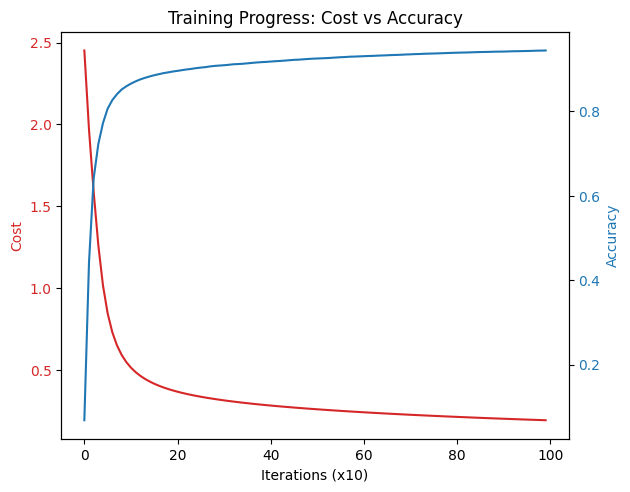

In [47]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations (x10)')
ax1.set_ylabel('Cost', color=color)
ax1.plot(costs, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(accs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Training Progress: Cost vs Accuracy")
plt.show()